In [19]:
from pyexpat import features
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from aiohttp.web_routedef import static
from mpmath import residual

df = pd.read_csv("/Users/lorenzoreinoso/Documents/MIT-StreetCar-Delay/dataset_with_has_delay.csv")

In [20]:
df.head()

,Week,Line,Location,Incident,Min Delay,Min Gap,Vehicle,has_delay,Year,Month,Day_of_Month,Hour,Minute,Bound_B,Bound_E,Bound_N,Bound_S,Bound_W
0,1,0.126664,0.000992,11,10,20,4416,0,2024,1,1,2,45,0,0,0,0,1
1,1,0.126664,0.000361,3,52,72,4461,1,2024,1,1,3,6,0,1,0,0,0
2,1,0.064381,0.000180,11,0,0,4545,0,2024,1,1,3,21,0,0,1,0,0
3,1,0.126664,0.020566,11,37,0,4551,1,2024,1,1,3,53,0,0,0,0,1
4,1,0.002645,0.005412,2,78,93,8116,1,2024,1,1,4,27,0,1,0,0,0


In [21]:
# Function created for aesthetic, if we have more than 3 values it adds a ...
def format_unique_values(values):
    if len(values) > 3:
        return f"{list(values[:3])} ... ({len(values)} unique values)"
    return list(values)

# This is added for structure
summary = {
    'Data Type': df.dtypes, # Luego el tipo de dato
    'Unique Values': [df[col].nunique() for col in df.columns], # luego el número de valores unicos
    'Sample Values': [format_unique_values(df[col].unique()) for col in df.columns], # Usando la función de arriba mostrar algunos valores
    'Missing Values': df.isnull().sum(), # Cantidad de valores Faltantes
    'Missing %': round(df.isnull().sum() / len(df) * 100,2) # Es la proporción cuantos valores hay faltantes
}

details = pd.DataFrame(summary)

# This part is added to format the final table
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
styled_details = details.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'),
                                ('color', 'black'),
                                ('font-weight', 'bold'),
                                ('text-align', 'left'),
                                ('padding', '8px')]},
    {'selector': 'td', 'props': [('padding', '8px')]}
])

display(styled_details)

# Final Resume
print("\nShape of the DF (rows, columns):", df.shape)
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

,Data Type,Unique Values,Sample Values,Missing Values,Missing %
Week,int64,40,"[1, 2, 3] ... (40 unique values)",0,0.000000
Line,float64,25,"[0.1266642349078971, 0.064380813, 0.002644538] ... (25 unique values)",0,0.000000
Location,float64,74,"[0.000992242, 0.000360815, 0.000180408] ... (74 unique values)",0,0.000000
Incident,int64,13,"[11, 3, 2] ... (13 unique values)",0,0.000000
Min Delay,int64,197,"[10, 52, 0] ... (197 unique values)",0,0.000000
Min Gap,int64,205,"[20, 72, 0] ... (205 unique values)",0,0.000000
Vehicle,int64,1076,"[4416, 4461, 4545] ... (1076 unique values)",0,0.000000
has_delay,int64,2,"[0, 1]",0,0.000000
Year,int64,1,[2024],0,0.000000
Month,int64,9,"[1, 2, 3] ... (9 unique values)",0,0.000000



Forma del DF (filas, columnas): (11086, 18)
Filas: 11086
Columnas: 18


Some the key aspects are that there are no categorical Values, also we can identify that there are no missing values.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Week          11086 non-null  int64  
 1   Line          11086 non-null  float64
 2   Location      11086 non-null  float64
 3   Incident      11086 non-null  int64  
 4   Min Delay     11086 non-null  int64  
 5   Min Gap       11086 non-null  int64  
 6   Vehicle       11086 non-null  int64  
 7   has_delay     11086 non-null  int64  
 8   Year          11086 non-null  int64  
 9   Month         11086 non-null  int64  
 10  Day_of_Month  11086 non-null  int64  
 11  Hour          11086 non-null  int64  
 12  Minute        11086 non-null  int64  
 13  Bound_B       11086 non-null  int64  
 14  Bound_E       11086 non-null  int64  
 15  Bound_N       11086 non-null  int64  
 16  Bound_S       11086 non-null  int64  
 17  Bound_W       11086 non-null  int64  
dtypes: float64(2), int64(16)
m

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Week,11086.0,19.597059,11.345300,1.00000,10.000000,19.000000,29.000000,40.000000
Line,11086.0,0.119323,0.057894,0.00000,0.080978,0.111891,0.155481,0.203903
Location,11086.0,0.004474,0.005577,0.00009,0.000722,0.002436,0.005773,0.022912
Incident,11086.0,5.459498,3.539217,0.00000,2.000000,5.000000,8.000000,12.000000
Min Delay,11086.0,15.443532,32.338755,0.00000,5.000000,10.000000,12.000000,873.000000
Min Gap,11086.0,23.237958,34.076949,0.00000,10.000000,20.000000,21.000000,883.000000
Vehicle,11086.0,4989.146852,2373.181658,0.00000,4454.000000,4526.000000,4596.000000,77624.000000
has_delay,11086.0,0.204853,0.403612,0.00000,0.000000,0.000000,0.000000,1.000000
Year,11086.0,2024.000000,0.000000,2024.00000,2024.000000,2024.000000,2024.000000,2024.000000
Month,11086.0,4.899874,2.587972,1.00000,3.000000,5.000000,7.000000,9.000000


In [24]:
df.columns

Index(['Week', 'Line', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Vehicle', 'has_delay', 'Year', 'Month', 'Day_of_Month', 'Hour', 'Minute', 'Bound_B', 'Bound_E', 'Bound_N', 'Bound_S', 'Bound_W'], dtype='object')

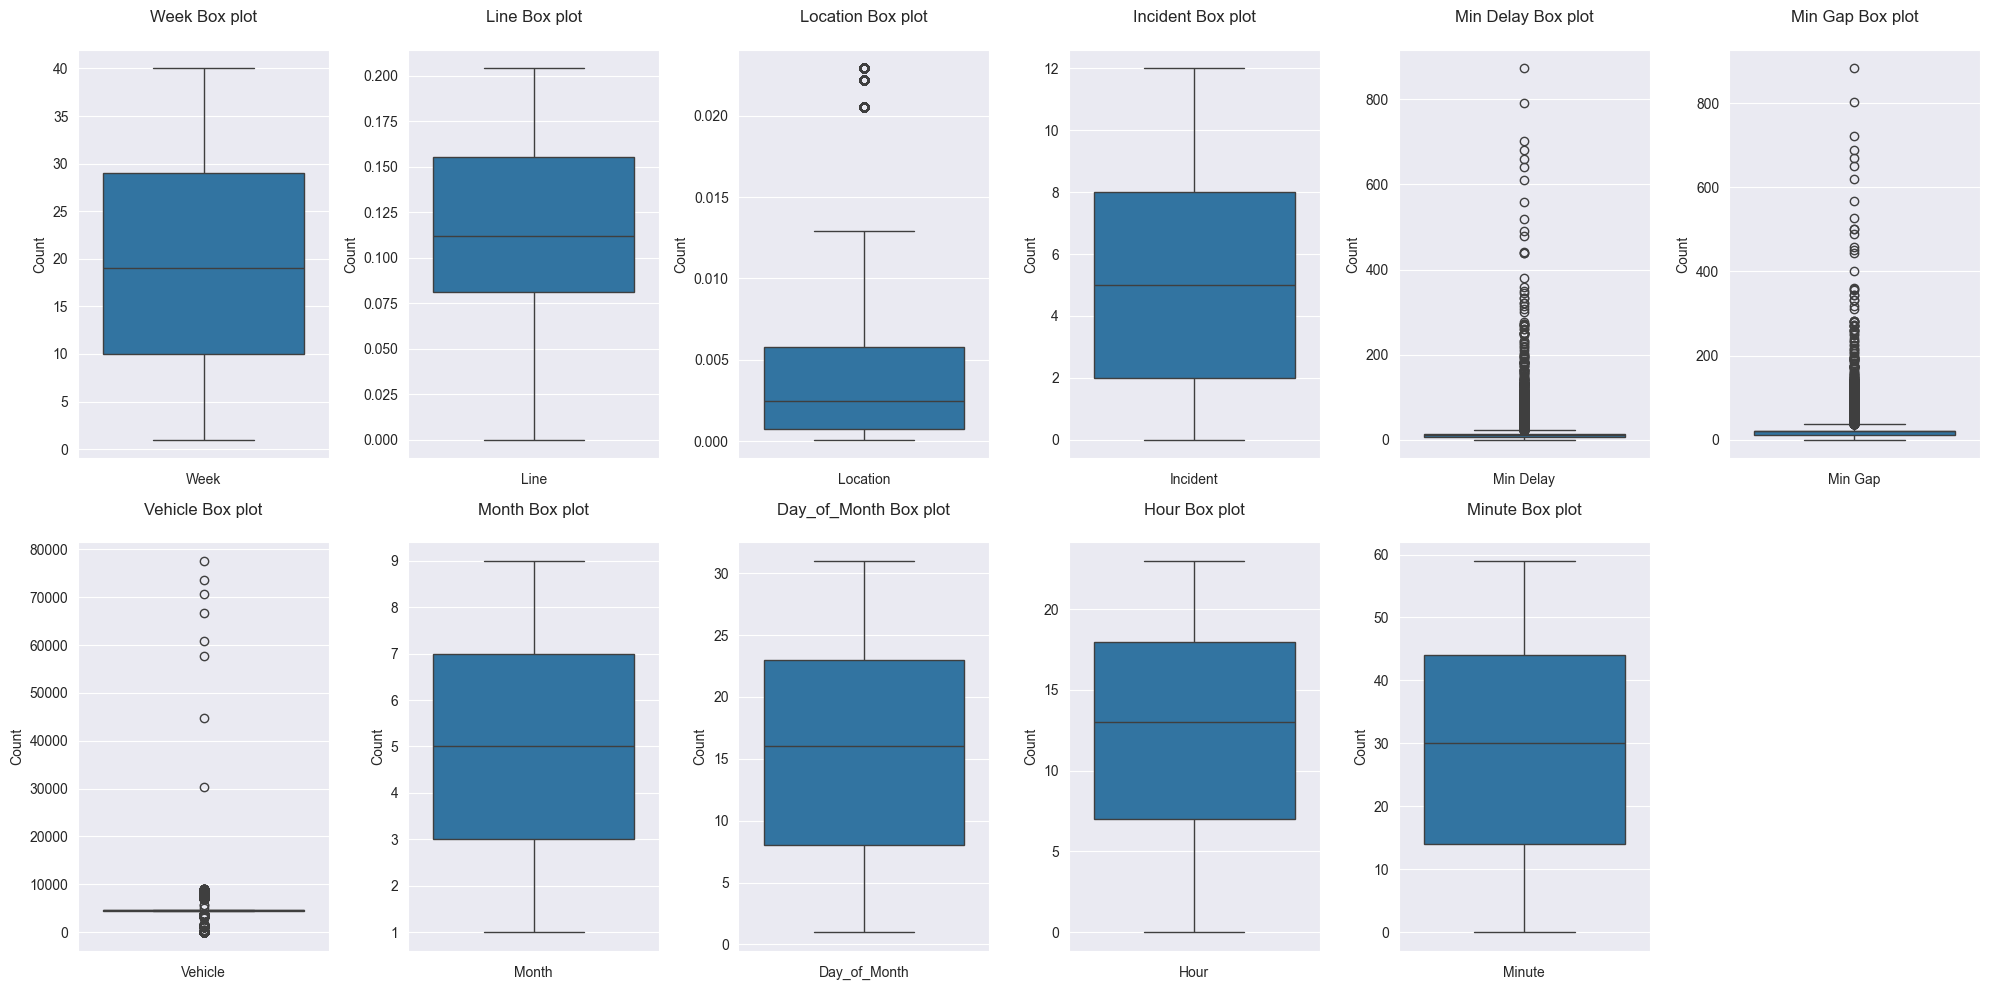

In [30]:
graficar_num = ['Week', 'Line', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Vehicle', 'Month', 'Day_of_Month', 'Hour', 'Minute']
plt.figure(figsize=(20, 10))

for idx, feature in enumerate(graficar_num, 1):
    plt.subplot(2, 6, idx)
    sns.boxplot(data=df, y=feature)
    plt.title(f'{feature} Box plot', pad=20)
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [3]:
df["Min Delay"].value_counts()

Min Delay
10     3804
0      1859
8       618
5       553
9       328
       ... 
358       1
873       1
196       1
308       1
640       1
Name: count, Length: 197, dtype: int64

In [4]:
df["Year"].value_counts()

Year
2024    11086
Name: count, dtype: int64

In [5]:
df.drop("Year", axis=1, inplace=True)  # axis=1 is preferred over axis="1"
df.head()

,Week,Line,Location,Incident,Min Delay,Min Gap,Vehicle,has_delay,Month,Day_of_Month,Hour,Minute,Bound_B,Bound_E,Bound_N,Bound_S,Bound_W
0,1,0.126664,0.000992,11,10,20,4416,0,1,1,2,45,0,0,0,0,1
1,1,0.126664,0.000361,3,52,72,4461,1,1,1,3,6,0,1,0,0,0
2,1,0.064381,0.000180,11,0,0,4545,0,1,1,3,21,0,0,1,0,0
3,1,0.126664,0.020566,11,37,0,4551,1,1,1,3,53,0,0,0,0,1
4,1,0.002645,0.005412,2,78,93,8116,1,1,1,4,27,0,1,0,0,0


In [6]:
df['TimeOfDay'] = df['Hour'] * 60 + df['Minute']
df.drop("Hour", axis=1, inplace=True)
df.drop("Minute", axis=1, inplace=True)
df.drop("has_delay", axis=1, inplace=True)
df.drop("Month", axis=1, inplace=True)
features = ['Week', 'Line', 'Location', 'Incident', 'TimeOfDay', 'Vehicle', 'Day_of_Month',
               'Bound_B', 'Bound_E', 'Bound_N', 'Bound_S', 'Bound_W']

In [7]:
df.corr()

,Week,Line,Location,Incident,Min Delay,Min Gap,Vehicle,Day_of_Month,Bound_B,Bound_E,Bound_N,Bound_S,Bound_W,TimeOfDay
Week,1.000000,-0.020557,-0.009163,-0.034631,0.024939,0.020689,-0.060901,0.133731,-0.013101,-0.006704,0.019671,-0.011252,0.006088,0.030967
Line,-0.020557,1.000000,0.013687,0.028875,-0.004731,0.001470,0.128248,0.009139,-0.007813,0.046890,-0.015952,-0.031101,0.058818,0.059876
Location,-0.009163,0.013687,1.000000,0.018223,-0.061398,-0.059584,0.010238,-0.007077,-0.009415,-0.119160,0.028824,0.054972,-0.096921,-0.039517
Incident,-0.034631,0.028875,0.018223,1.000000,-0.135734,-0.140222,0.059059,0.010761,-0.015963,-0.028856,0.017257,0.018055,-0.028703,-0.059952
Min Delay,0.024939,-0.004731,-0.061398,-0.135734,1.000000,0.963514,-0.047443,-0.003235,-0.004101,0.033471,-0.022565,-0.038515,0.012643,-0.006342
Min Gap,0.020689,0.001470,-0.059584,-0.140222,0.963514,1.000000,-0.043295,-0.006595,-0.006881,0.036256,-0.024671,-0.039615,0.023154,-0.013630
Vehicle,-0.060901,0.128248,0.010238,0.059059,-0.047443,-0.043295,1.000000,0.004764,-0.006371,0.036593,0.045068,0.021448,0.030474,0.007701
Day_of_Month,0.133731,0.009139,-0.007077,0.010761,-0.003235,-0.006595,0.004764,1.000000,0.005532,0.009078,-0.025333,-0.002130,0.006074,0.020246
Bound_B,-0.013101,-0.007813,-0.009415,-0.015963,-0.004101,-0.006881,-0.006371,0.005532,1.000000,-0.014392,-0.007671,-0.007766,-0.014329,-0.013444
Bound_E,-0.006704,0.046890,-0.119160,-0.028856,0.033471,0.036256,0.036593,0.009078,-0.014392,1.000000,-0.244684,-0.247702,-0.457053,-0.000874


<Axes: >

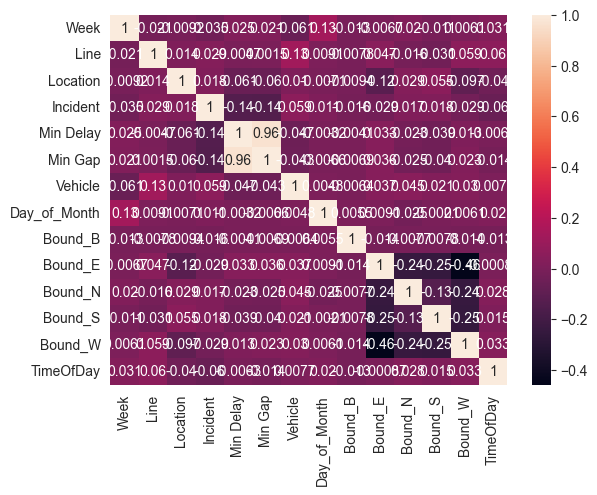

In [8]:
sns.heatmap(df.corr(),annot=True)

<Axes: xlabel='Min Delay', ylabel='Density'>

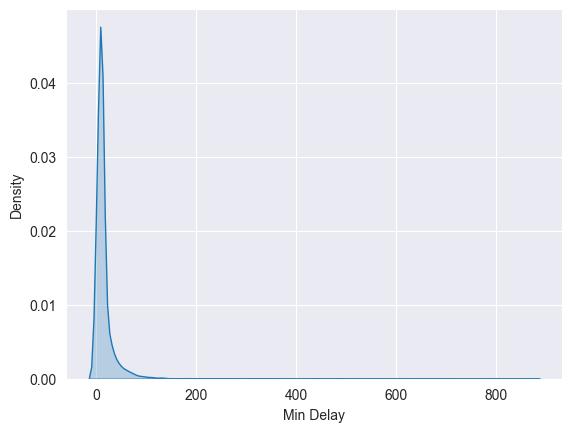

In [9]:
sns.kdeplot(df,x="Min Delay", fill=True)

<Axes: ylabel='Min Delay'>

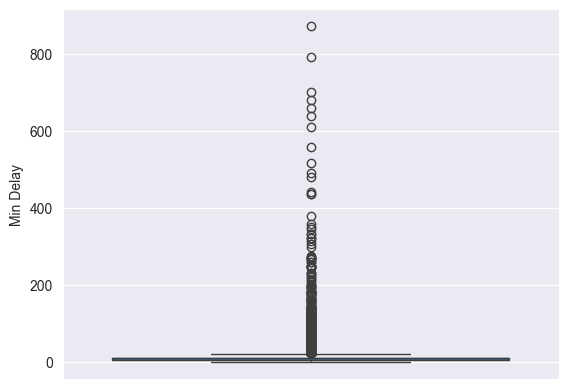

In [10]:
sns.boxplot(df,y="Min Delay")

In [11]:
df[['Min Delay', 'Min Gap']].describe()

,Min Delay,Min Gap
count,11086.000000,11086.000000
mean,15.443532,23.237958
std,32.338755,34.076949
min,0.000000,0.000000
25%,5.000000,10.000000
50%,10.000000,20.000000
75%,12.000000,21.000000
max,873.000000,883.000000


In [12]:
df['Min Delay'].corr(df['Min Gap'])
correlation = df['Min Delay'].corr(df['Min Gap'])
print(f"\nCorrelation betweena Min Delay and Min Gap: {correlation:.2f}")


Correlation betweena Min Delay and Min Gap: 0.96


<Axes: ylabel='Min relation'>

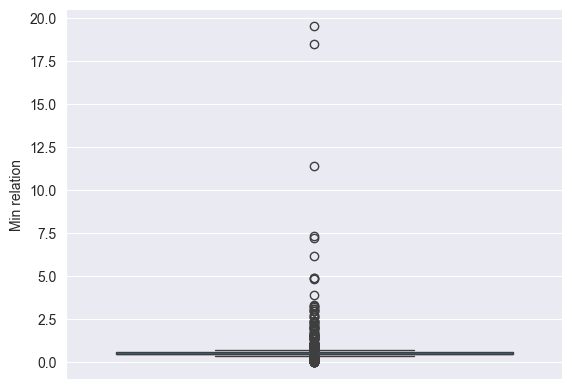

In [13]:
df["Min relation"] = df["Min Delay"]/df["Min Gap"]
sns.boxplot(df,y="Min relation")

Original dataset size: 11086
After removing outliers: 7747

Summary statistics for cleaned Min relation:
count    7747.000000
mean        0.523422
std         0.067569
min         0.352941
25%         0.500000
50%         0.500000
75%         0.500000
max         0.750000
Name: Min relation, dtype: float64


Text(0, 0.5, 'Min Delay / Min Gap Ratio')

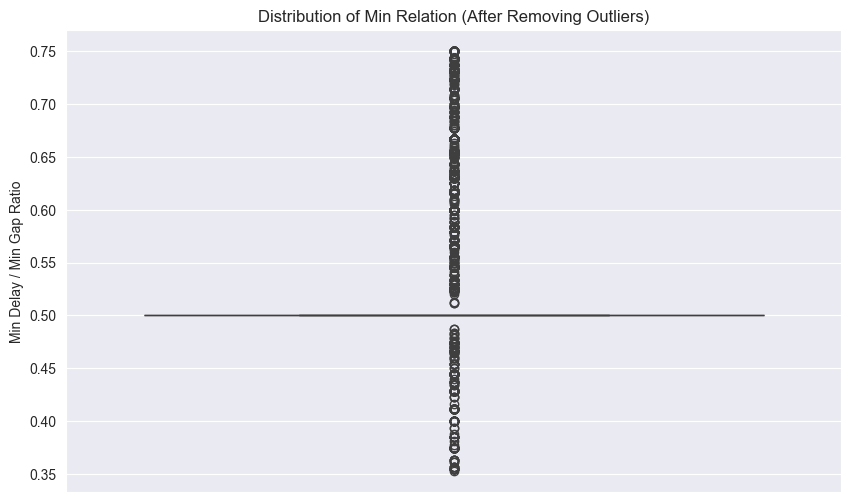

In [14]:
import pandas as pd
import numpy as np

def remove_outliers_iqr(df, column, k=1.5):
    """
    Remove outliers using the IQR method

    Parameters:
    df: DataFrame
    column: str, column name to check for outliers
    k: float, multiplier for IQR (default=1.5)

    Returns:
    DataFrame with outliers removed
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from Min relation
df_clean = remove_outliers_iqr(df, 'Min relation')

# Print summary statistics before and after
print("Original dataset size:", len(df))
print("After removing outliers:", len(df_clean))
print("\nSummary statistics for cleaned Min relation:")
print(df_clean['Min relation'].describe())

# Optionally, if you want to clean the original metrics as well
df_very_clean = df_clean[
    (df_clean['Min Delay'] <= df_clean['Min Delay'].quantile(0.95)) &
    (df_clean['Min Gap'] <= df_clean['Min Gap'].quantile(0.95))
]

# Create visualization of cleaned data
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, y='Min relation')
plt.title('Distribution of Min Relation (After Removing Outliers)')
plt.ylabel('Min Delay / Min Gap Ratio')

In [15]:
df.drop("Min Gap", axis=1, inplace=True)
df.drop("Min Delay", axis=1, inplace=True)


In [16]:
#sns.boxplot(df,y="Min Gap", hue="Min Delay")

In [17]:
X = df.drop(df.columns[-1],axis=1)
y = df['Min Delay']

KeyError: 'Min Delay'

In [ ]:
sns.heatmap(df.corr(),annot=True)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.pipeline import Pipeline

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipelines for different models
pipelines = {
    'rf': Pipeline([
        ('scaler', RobustScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'gb': Pipeline([
        ('scaler', RobustScaler()),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    'xgb': Pipeline([
        ('scaler', RobustScaler()),
        ('model', xgb.XGBRegressor(random_state=42))
    ])
}

# Define parameter grids for each model
param_grids = {
    'rf': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5]
    },
    'gb': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'xgb': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    }
}

# Train and evaluate models
best_models = {}
results = {}

for name, pipeline in pipelines.items():
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    # Evaluate on test set
    y_pred = grid_search.predict(X_test)
    results[name] = {
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'best_params': grid_search.best_params_
    }

# Find best model
best_model_name = min(results, key=lambda x: results[x]['rmse'])
best_model = best_models[best_model_name]

# Print results
for name in results:
    print(f"\n{name.upper()} Results:")
    print(f"RMSE: {results[name]['rmse']:.2f}")
    print(f"R2 Score: {results[name]['r2']:.2f}")
    print("Best Parameters:", results[name]['best_params'])

print(f"\nBest Model: {best_model_name.upper()}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan

def exploratory_analysis(df):
    plt.figure(figsize=(15, 5))

    # Distribución de delays
    plt.subplot(131)
    sns.histplot(data=df, x='Min Delay', bins=30)
    plt.title('Distribución de Delays')

    # Delays por tipo de incidente
    plt.subplot(133)
    sns.boxplot(data=df, x='Incident', y='Min Delay')
    plt.xticks(rotation=45)
    plt.title('Delays por Tipo de Incidente')

    plt.tight_layout()
    plt.show()

    # Matriz de correlación
    plt.figure(figsize=(10, 8))
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlación')
    plt.show()

def check_model_assumptions(y_true, y_pred, residuals):
    fig = plt.figure(figsize=(15, 5))

    # Q-Q plot
    ax1 = fig.add_subplot(131)
    stats.probplot(residuals, dist="norm", plot=ax1)
    ax1.set_title("Q-Q Plot de Residuos")

    # Histograma de residuos
    ax2 = fig.add_subplot(132)
    sns.histplot(residuals, kde=True, ax=ax2)
    ax2.set_title("Distribución de Residuos")

    # Residuos vs Valores Predichos
    ax3 = fig.add_subplot(133)
    sns.scatterplot(x=y_pred, y=residuals, ax=ax3)
    ax3.axhline(y=0, color='r', linestyle='--')
    ax3.set_title("Residuos vs Valores Predichos")

    plt.tight_layout()
    plt.show()

    # Test de Shapiro-Wilk
    shapiro_test = stats.shapiro(residuals)
    print("\nTest de Shapiro-Wilk para Normalidad:")
    print(f"Estadístico: {shapiro_test[0]:.4f}")
    print(f"P-valor: {shapiro_test[1]:.4f}")

    # Test de Breusch-Pagan para homocedasticidad
    # Preparar los datos para el test
    X = y_pred.reshape(-1, 1)  # Variables independientes
    bp_test = het_breuschpagan(residuals, X)
    print("\nTest de Breusch-Pagan para Homocedasticidad:")
    print(f"Estadístico: {bp_test[0]:.4f}")
    print(f"P-valor: {bp_test[1]:.4f}")


# Preparar los datos
df_clean = df

# Realizar análisis exploratorio
print("Realizando análisis exploratorio...")
exploratory_analysis(df_clean)

# Preparar variables para el modelo
X = df_clean[features]
y = df_clean['Min Delay']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Calcular residuos
residuos = y_test - y_pred_test

# Verificar supuestos del modelo
check_model_assumptions(y_test, y_pred_test, residuos)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def prepare_data(df, target_col='Min Delay', test_size=0.2):
    """
    Prepare data for modeling with proper train-test split and scaling
    """
    # Separate features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    return X_train, X_test, y_train, y_test

def create_models():
    """
    Create a dictionary of models with appropriate preprocessing pipelines
    """
    models = {
        'robust_linear': Pipeline([
            ('scaler', RobustScaler()),
            ('regressor', TransformedTargetRegressor(
                regressor=LinearRegression(),
                transformer=PowerTransformer(standardize=True)
            ))
        ]),
        'huber': Pipeline([
            ('scaler', RobustScaler()),
            ('regressor', TransformedTargetRegressor(
                regressor=HuberRegressor(epsilon=1.35),
                transformer=PowerTransformer(standardize=True)
            ))
        ]),
        'ridge': Pipeline([
            ('scaler', RobustScaler()),
            ('regressor', TransformedTargetRegressor(
                regressor=Ridge(alpha=1.0),
                transformer=PowerTransformer(standardize=True)
            ))
        ]),
        'rf': Pipeline([
            ('scaler', RobustScaler()),
            ('regressor', RandomForestRegressor(
                n_estimators=200,
                max_depth=None,
                min_samples_split=2,
                random_state=42
            ))
        ]),
        'xgb': Pipeline([
            ('scaler', RobustScaler()),
            ('regressor', xgb.XGBRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=5,
                random_state=42
            ))
        ])
    }
    return models

def evaluate_models(models, X_train, X_test, y_train, y_test):
    """
    Evaluate multiple models using cross-validation and test set
    """
    results = {}

    for name, model in models.items():
        # Fit model
        model.fit(X_train, y_train)

        # Cross-validation scores
        cv_scores = cross_val_score(
            model, X_train, y_train,
            cv=KFold(n_splits=5, shuffle=True, random_state=42),
            scoring='neg_root_mean_squared_error'
        )

        # Test set predictions
        y_pred = model.predict(X_test)

        # Store results
        results[name] = {
            'cv_rmse': -cv_scores.mean(),
            'cv_rmse_std': cv_scores.std(),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'test_mae': mean_absolute_error(y_test, y_pred),
            'test_r2': r2_score(y_test, y_pred),
            'model': model
        }

    return results

def analyze_residuals(model, X_test, y_test, title=""):
    """
    Analyze residuals of the model with various diagnostic plots
    """
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Residual Analysis - {title}', fontsize=16)

    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axes[0, 0])
    axes[0, 0].set_title("Q-Q Plot")

    # Residuals vs Predicted
    axes[0, 1].scatter(y_pred, residuals)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel("Predicted Values")
    axes[0, 1].set_ylabel("Residuals")
    axes[0, 1].set_title("Residuals vs Predicted")

    # Residual distribution
    sns.histplot(residuals, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title("Residual Distribution")

    # Scale-Location plot
    axes[1, 1].scatter(y_pred, np.sqrt(np.abs(residuals)))
    axes[1, 1].set_xlabel("Predicted Values")
    axes[1, 1].set_ylabel("√|Residuals|")
    axes[1, 1].set_title("Scale-Location Plot")

    plt.tight_layout()
    plt.show()

def print_results(results):
    """
    Print formatted results for all models
    """
    print("\nModel Evaluation Results:")
    print("-" * 80)
    print(f"{'Model':<15} {'CV RMSE':<15} {'Test RMSE':<15} {'Test MAE':<15} {'Test R²':<15}")
    print("-" * 80)

    for name, metrics in results.items():
        print(f"{name:<15} "
              f"{metrics['cv_rmse']:<15.2f} "
              f"{metrics['test_rmse']:<15.2f} "
              f"{metrics['test_mae']:<15.2f} "
              f"{metrics['test_r2']:<15.2f}")

    # Find best model
    best_model = min(results.items(), key=lambda x: x[1]['test_rmse'])
    print("\nBest Model:", best_model[0])
    print(f"Test RMSE: {best_model[1]['test_rmse']:.2f}")

def run_analysis(df):
    """
    Run the complete analysis pipeline
    """
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data(df)

    # Create and evaluate models
    models = create_models()
    results = evaluate_models(models, X_train, X_test, y_train, y_test)

    # Print results
    print_results(results)

    # Analyze residuals for best model
    best_model_name = min(results.items(), key=lambda x: x[1]['test_rmse'])[0]
    analyze_residuals(
        results[best_model_name]['model'],
        X_test,
        y_test,
        title=best_model_name
    )

    return results

In [ ]:
# Assuming your DataFrame is named df
results = run_analysis(df)

# To analyze a specific model's residuals in more detail
best_model_name = min(results.items(), key=lambda x: x[1]['test_rmse'])[0]
analyze_residuals(
    results[best_model_name]['model'],
    X_test,
    y_test,
    title=best_model_name
)